In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import pickle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')


Success


## Purpose

This notebook calculates the uncertainty on the in-cryostat $\nu$ sample due to the detector modelling. The uncertainty is then saved in the BDT score .root files. <br>
This uncertainty is required for the final limit calculation. 

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_lepton_signal":False, #Load ee BDTs
          "Load_pi0_signal":True, #Load pi0 BDTs
          "Use_logit":True} 

loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"
end_str = "_full_Finished"

samples = Constants.Detector_variations
        
sample_test_dict = {}
for sample in samples:
    loc=loc_pkls+f"DetVars/Preselected_overlay_{sample}_"+Params["Run"]+f"_flattened_reduced_evs{end_str}.pkl"
    sample_test_dict[sample] = pd.read_pickle(loc)
print("Loaded all " + Params["Run"] + " overlay detector variation samples.")

Loaded all run3 overlay detector variation samples.


In [3]:

BDT_name = "_full_Finished_10"

if Params["Load_pi0_signal"] == False:
    with open(f"bdts/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)
elif Params["Load_pi0_signal"] == True:
    with open(f"bdts/pi0_selection/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)

bdt_vars = saved_variables
xgb_test_dict = {}

for sample in sample_test_dict:
    xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])
    
if Params["Load_pi0_signal"] == False:
    for HNL_mass in Constants.HNL_mass_samples:
        # bdt = xgboost.Booster() #OLD way of loading BDT models.
        # bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_ee" + BDT_name+".json") #OLD way of loading BDT models.
        filename = "bdts/"+Params["Run"]+f"_{HNL_mass}_ee{BDT_name}.pkl"
        bdt = pickle.load(open(filename, "rb"))
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        # bdt = xgboost.Booster() #OLD way of loading BDT models.
        # bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_pi0{BDT_name}.json")
        filename = "bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_pi0{BDT_name}.pkl"
        bdt = pickle.load(open(filename, "rb"))
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            

In [4]:

def make_stat_err(hist, SF):
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

In [5]:
def safe_div(x,y):
    if y == 0.0:
        return 0
    return x / y

def Calc_RMS_quadsum(CV_hist, dict_detvar_hists): #Currently assuming "mean" value to be the CV, I believe this is the correct thing to do
    nbins = len(CV_hist)
    RMS_on_bins = np.zeros(nbins)
    Quad_sum_on_bins = np.zeros(nbins)
    RMS_on_bins_frac = np.zeros(nbins)
    Quad_sum_on_bins_frac = np.zeros(nbins)
    num_samples = len(dict_detvar_hists) #This should NOT include the CV hist
    for j in range(nbins): #Looping over bins
        sum_diffs_squared = 0
        for detvar in dict_detvar_hists:
            diff = dict_detvar_hists[detvar][j]-CV_hist[j] #Difference between the number in the CV sample and the DetVar sample
            sum_diffs_squared += diff**2
        variance = sum_diffs_squared/num_samples
        RMS_on_bins[j] = np.sqrt(variance) #The total RMS error on the bin
        Quad_sum_on_bins[j] = np.sqrt(sum_diffs_squared)
        RMS_on_bins_frac[j] = safe_div(np.sqrt(variance),CV_hist[j]) #Need to calculate here to avoid problems with zero divisor
        Quad_sum_on_bins_frac[j] = safe_div(np.sqrt(sum_diffs_squared),CV_hist[j])
              
    return {"RMS":RMS_on_bins, "quadsum":Quad_sum_on_bins, "RMS_frac":RMS_on_bins_frac, "quadsum_frac":Quad_sum_on_bins_frac}

def Calc_frac_diff(CV_hist, dict_detvar_hists):
    nbins = len(CV_hist)
    frac_diff_dict = {}
    perc_diff_dict = {}
    for detvar in dict_detvar_hists: #Should NOT contain CV hist
        frac_diff_on_bins = np.zeros(nbins)
        perc_diff_on_bins = np.zeros(nbins)
        for j in range(nbins): #Looping over bins
            frac = safe_div(dict_detvar_hists[detvar][j],CV_hist[j])
            frac_diff = frac - 1.0
            perc_diff = (frac_diff*100)
            frac_diff_on_bins[j] = frac_diff
            perc_diff_on_bins[j] = perc_diff
        frac_diff_dict[detvar] = frac_diff_on_bins
        perc_diff_dict[detvar] = perc_diff_on_bins
           
    return frac_diff_dict, perc_diff_dict

def Calc_stat_err(CV_hist, CV_hist_unweighted): #Calculate the statistical (Poisson) error on each bin for the central value histogram
    nbins = len(CV_hist)
    stat_err_on_bins = np.zeros(nbins)
    for j in range(nbins): #Looping over bins
        poisson_err = np.sqrt(CV_hist_unweighted[j])
        SF = CV_hist_unweighted[j]/CV_hist[j] #The factor this bin is scaled by due to weighting
        stat_err_on_bins[j] = poisson_err*SF #Need to scale the Poisson error by whatever the total scaling on the bin is
    return stat_err_on_bins


## Plotting overlay Detector variations

In [6]:
bins_dict, bin_cents = {}, {}
name_type = Functions.Get_signal_name_type(Params)

filename = name_type+BDT_name+'.root'

if Params["Load_pi0_signal"] == False:
    HNL_masses = Constants.HNL_mass_samples
    saved_loc = f'bdt_output/'
if Params["Load_pi0_signal"] == True:
    HNL_masses = Constants.HNL_mass_pi0_samples
    saved_loc = f'bdt_output/pi0/'
    
for HNL_mass in HNL_masses:
    hist_placeholder = uproot.open(saved_loc+Params["Run"]+f'_{HNL_mass}_'+filename)
    bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
    bin_cents[HNL_mass] = (np.array(bins_dict[HNL_mass][:-1])+np.array(bins_dict[HNL_mass][1:]))/2
print("Loaded bins for " + str(bins_dict.keys()))

Loaded bins for dict_keys([150, 180, 200, 220, 240, 245])


In [7]:
sample_test_dict.keys()

dict_keys(['WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV'])

In [8]:
def make_overflow_bin(bins_dict, bins_cents_dict):
    """
    For making the final "overflow" bin the same size as the previous bins, i.e one integer in width.
    """
    bins_overflow, bins_cent_overflow = {}, {}
    for HNL_mass in bins_dict:
        overflow_bin = bins_cents_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin centre val. 
        bins_cent_overflow[HNL_mass] = bins_cents_dict[HNL_mass].copy()
        bins_cent_overflow[HNL_mass][-1] = overflow_bin
        bins_overflow[HNL_mass] = bins_dict[HNL_mass].copy()
        bins_overflow[HNL_mass][-1] = bins_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin end val. 
    return bins_overflow, bins_cent_overflow

bins_overflow, bins_cents_overflow = make_overflow_bin(bins_dict, bin_cents)

def make_xlims_dict(bins_dict, spacing, lower = None):
    """
    Making a dict of xlims for plotting several mass points at once.
    Also returns a dict of xticks for the purpose of indicating the overflow.
    """
    xlims_adjusted, xticks_adjusted = {}, {}
    vals_dict={}
    for HNL_mass in bins_dict:
        if isinstance(lower,(int, float)): lower_val = lower
        else: lower_val = bins_dict[HNL_mass][0]
        xlims_adjusted[HNL_mass] = [lower_val,bins_dict[HNL_mass][-1]]
        ticks = np.arange(bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1], spacing)
        if ticks[-1] != bins_dict[HNL_mass][-2]: ticks = np.append(ticks, bins_dict[HNL_mass][-1]-1)
        ticks_strings = []
        vals = []
        for val in ticks:
            ticks_strings.append(str(int(val)))
            vals.append(val)
        ticks_strings[-1] = str(ticks_strings[-1])+"+"
        xticks_adjusted[HNL_mass] = ticks_strings
        vals_dict[HNL_mass] = vals
        
    return xlims_adjusted, xticks_adjusted, vals_dict

xlims_dict, xticks_dict, vals_dict = make_xlims_dict(bins_overflow, 2)

In [9]:
print(HNL_masses)
print(Constants.Detector_variations)

[150, 180, 200, 220, 240, 245]
['WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV']


In [10]:
def Plot_all_detvar_diffs(sample_dict, HNL_masses, bins_original, bins_cent_dict, bins_dict, 
                          xlims_dict, xticks_dict,xticks_vals, xlim_start=-5, y_lim=50, bin_padding=4, hlines=[]):
    """
    Plot all detector variations differences from the CV sample.
    """
    DetVar_percentages_dict = {}
    quadsum_var_dict = {}
    
    plt.rcParams.update({'font.size': 28})

    figsize=(14, 6)
    linewidth = 1
    # h_lines = [15] #Line displaying this % difference

    quadsum_dict = {}

    num_bins_signal_region = 3 #Number of last bins classified as the "signal region"
    
    savefig = input("Do you want to save the plots? y/n ")

    # for HNL_mass in HNL_masses: #Looping over all mass points
    for HNL_mass in HNL_masses: #Looping over all mass points
        # HNL_mass = int(sample_name.split("_")[0])
        print(f"Plotting {HNL_mass} histogram") 

        bins = bins_original[HNL_mass]
        nbins = len(bins)-1
        xrange = [bins_original[HNL_mass][0], bins_original[HNL_mass][-1]]
        # xlims = [bins_dict[HNL_mass][0],bins_dict[HNL_mass][-1]+5]
        xlims = [xlim_start,xlims_dict[HNL_mass][-1]+bin_padding]
        xticks = xticks_dict[HNL_mass]

        plt.figure(figsize=figsize,facecolor='white')
        RMS=np.zeros(nbins)
        frac_RMS=np.zeros(nbins)
        quad_sum=np.zeros(nbins)
        frac_quad_sum=np.zeros(nbins)
        sum_squares = np.zeros(nbins)
        stat_err = np.zeros(nbins)
        SF_on_bin = np.zeros(nbins)
        upvals = np.zeros(nbins+1)
        lowvals = np.zeros(nbins+1)
        upvals_frac = np.zeros(nbins+1)
        lowvals_frac = np.zeros(nbins+1)
        x_coords = bins_dict[HNL_mass]
        max_y = 0

        # cv_hist, cv_bins = np.histogram(Functions.logit(sample_test_dict[f"CV"][f'BDT_output_{HNL_mass}MeV']),
        #                                 range=xrange, bins=bins)  #Was doing this
        
        cv_hist, cv_bins = np.histogram(Functions.logit(sample_test_dict[f"CV"][f'BDT_output_{HNL_mass}MeV']),
                                        range=xrange, bins=bins, weights=sample_test_dict[f"CV"]["weight"])
        
        # bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
        bins_cent = bins_cent_dict[HNL_mass]
        # for DetVar in Constants.Detector_variations:
        frac_diff_dict = {}
        for DetVar in Constants.Detector_variations:
            if DetVar == "CV":
                continue
            perc_list = []

            detvar_hist, bins = np.histogram(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']),
                                             bins=bins, weights=sample_test_dict[DetVar]["weight"])
            for i in range(len(detvar_hist)):
                frac = safe_div(detvar_hist[i],cv_hist[i])
                frac_diff = frac - 1.0
                perc_list.append(frac_diff*100)
        
            DetVar_percentages_dict[DetVar] = perc_list

            plt.hist(bins_cent,weights=DetVar_percentages_dict[DetVar], bins=bins_dict[HNL_mass],range=xrange,label=f'{DetVar}',
                     lw=linewidth,histtype="step")

        # quadsum_var_dict[HNL_mass] = frac_diff_dict
        cv_no_weighting = np.histogram(Functions.logit(sample_test_dict[f"CV"][f'BDT_output_{HNL_mass}MeV']),
                                           bins=bins)[0]
        
        for j in range(len(cv_hist)):
            for sample in xgb_test_dict:
                if sample=="CV":
                    continue

                hist_input = Functions.logit(sample_test_dict[sample][f'BDT_output_{HNL_mass}MeV'])

                # detvar_hist, bins = np.histogram(hist_input, 
                #                                  bins=bins) #Was doing this before, gave some odd looking 
                detvar_hist, bins = np.histogram(hist_input, 
                                                 bins=bins, weights=sample_test_dict[sample]["weight"])

                diff = cv_hist[j] - detvar_hist[j]
                diff_squared = diff**2
                sum_squares[j] = sum_squares[j]+diff_squared

                # SF_on_bin[j] = cv_hist[j]/cv_no_weighting[j] #This effective scale factor comes in by weighting on events
                SF_on_bin[j] = safe_div(cv_hist[j],cv_no_weighting[j])
                stat_err[j] = np.sqrt(cv_no_weighting[j])
                upvals[j] = cv_hist[j]+stat_err[j]
                lowvals[j] = cv_hist[j]-stat_err[j]
                upvals_frac[j] = safe_div(upvals[j],cv_hist[j])*100-100
                lowvals_frac[j] = safe_div(lowvals[j],cv_hist[j])*100-100

            RMS[j] = np.sqrt(sum_squares[j]/(len(Constants.Detector_variations)-1))
            frac_RMS[j] = safe_div(RMS[j],cv_hist[j])
            quad_sum[j] = np.sqrt(sum_squares[j])
            frac_quad_sum[j] = safe_div(quad_sum[j],cv_hist[j]) #quad_sum[j]/cv_hist[j]
            
        quadsum_dict[HNL_mass] = frac_quad_sum
        max_y = max(frac_quad_sum)
        # ylims = [max_y*(-1.2)*100, max_y*(1.2)*100]
        ylims = [-1*y_lim, y_lim]
        plt.hist(bins_cent, weights=frac_quad_sum*100, bins=bins_dict[HNL_mass],label=f'Quadrature sum',lw=linewidth+2,
                 histtype="step", color="black")
        plt.hist(bins_cent, weights=frac_quad_sum*(-100), bins=bins_dict[HNL_mass],lw=linewidth+2,
                 histtype="step", color="black")

        plt.fill_between(x_coords, lowvals_frac, upvals_frac, step="post",color="grey",alpha=0.3,zorder=2)

        plt.legend(loc='center right',frameon=True, framealpha=1.0, fontsize=18)
        plt.ylim(ylims)
        print(xlims)
        plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{HNL_mass} MeV)', fontsize=30)
        plt.ylabel('% Difference', fontsize=30)

        for h_line in hlines:
            if max_y*100 > h_line:
                plt.axhline(y=h_line, lw=2, color='green', linestyle = 'dashed')
                plt.axhline(y=-1*(h_line), lw=2, color='green', linestyle = 'dashed')
                ypos_factor = y_lim/10
                plt.text(-4, h_line+ypos_factor, f"{h_line}%", color='green')

        plt.xticks(ticks=xticks_vals[HNL_mass], labels=xticks)
        
        plt.xlim(xlims)

        plt.tight_layout()
        
        if savefig == "y":
            if Params["Load_lepton_signal"] == True:
                save_loc = "plots/Sys_uncertainty/Overlay/DetVar/Overlay_DetVars_quadsum_"
                end_name = "_ee"
            if Params["Load_pi0_signal"] == True: 
                save_loc = "plots/Sys_uncertainty/Overlay/DetVar/Overlay_DetVars_quadsum_"
                end_name = "_pi0"
            plt.savefig(save_loc + Params["Run"] + "_" + str(HNL_mass) + end_name + ".pdf")
            plt.savefig(save_loc + Params["Run"] + "_" + str(HNL_mass) + end_name + ".png")
        # if display == False:
        #         plt.close()
    return quadsum_dict


Do you want to save the plots? y/n  n


Plotting 150 histogram
[-8, 12.0]
Plotting 180 histogram
[-8, 12.0]
Plotting 200 histogram
[-8, 12.0]
Plotting 220 histogram
[-8, 11.0]
Plotting 240 histogram
[-8, 11.0]
Plotting 245 histogram
[-8, 11.0]


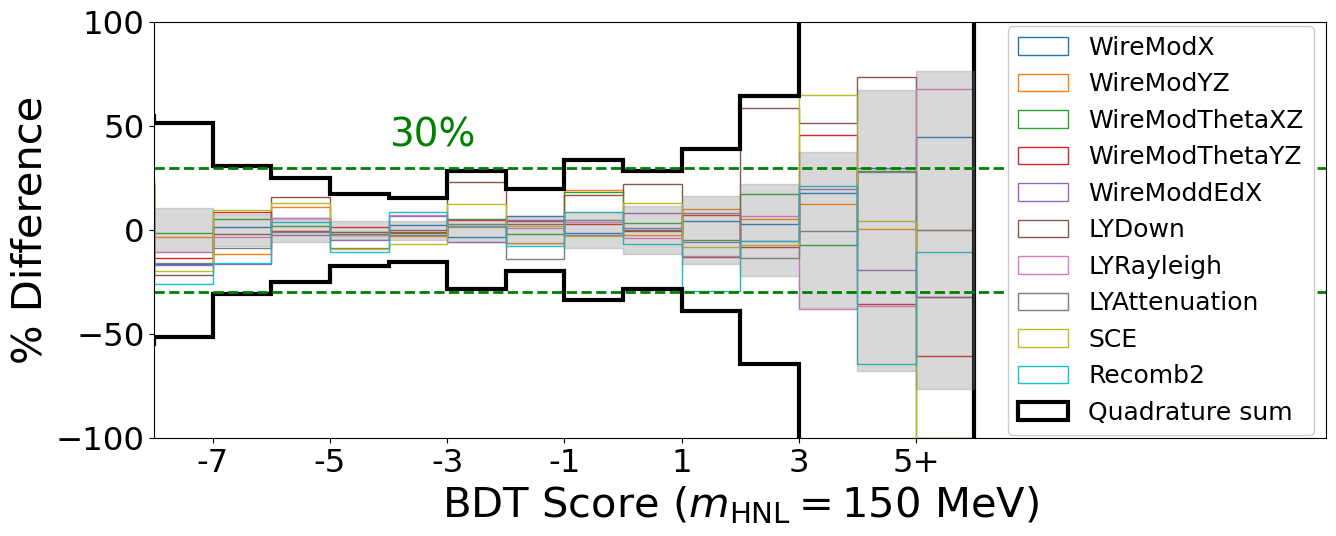

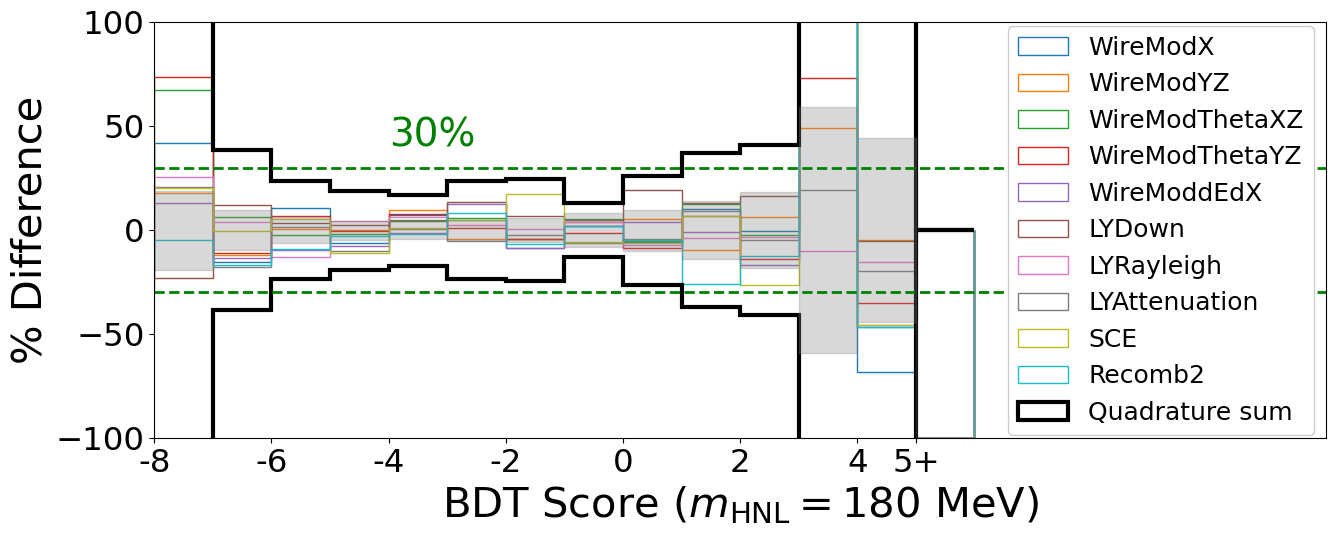

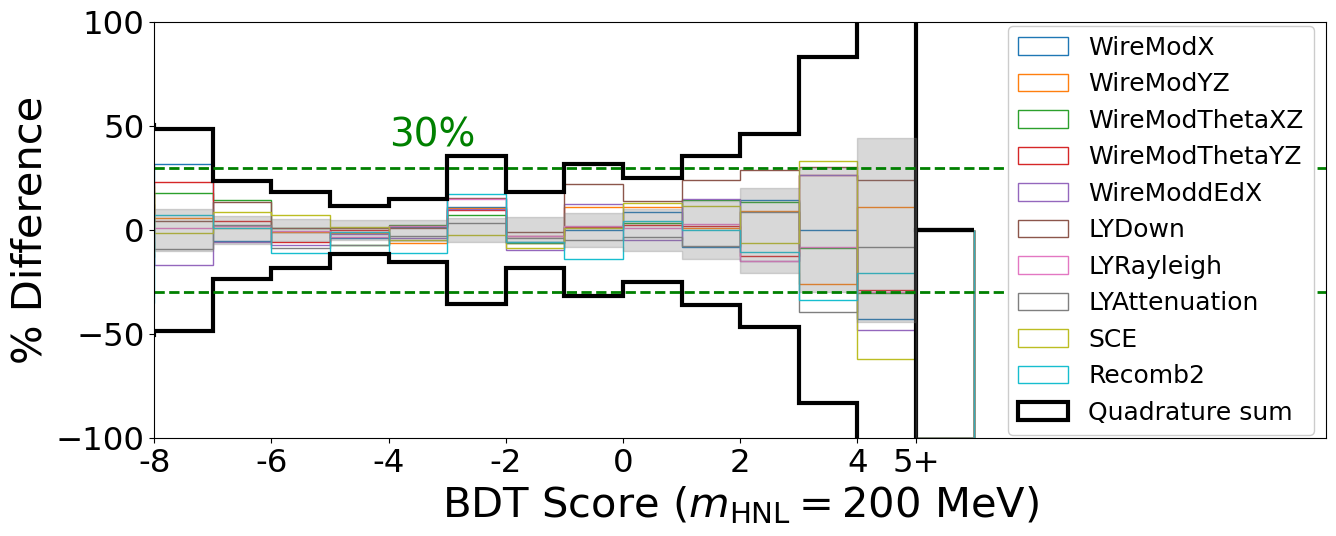

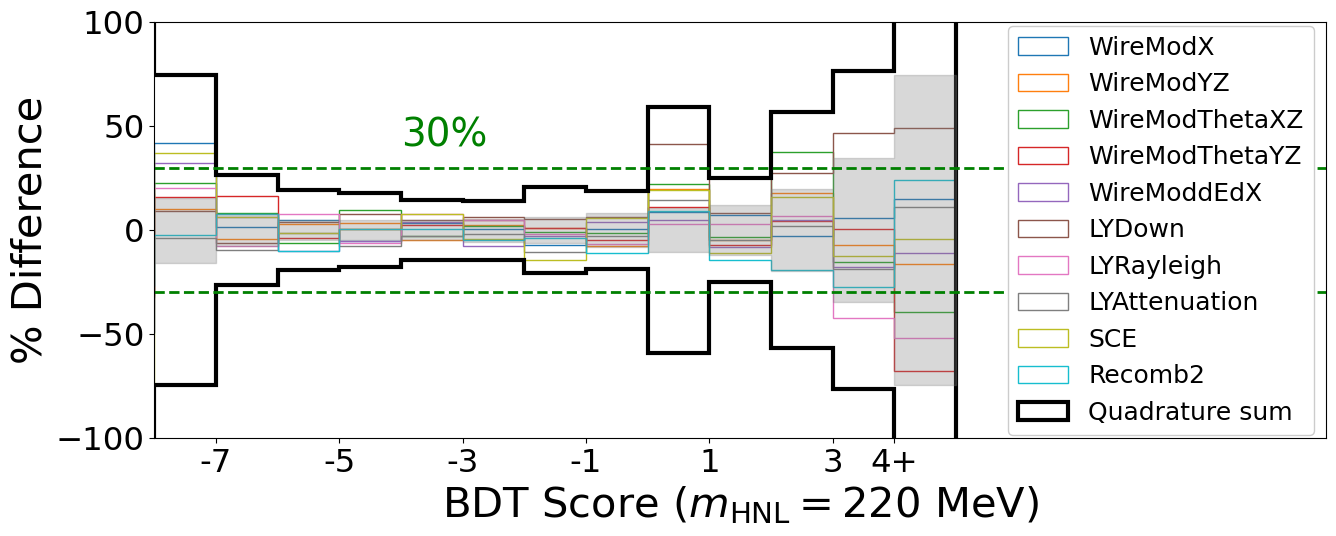

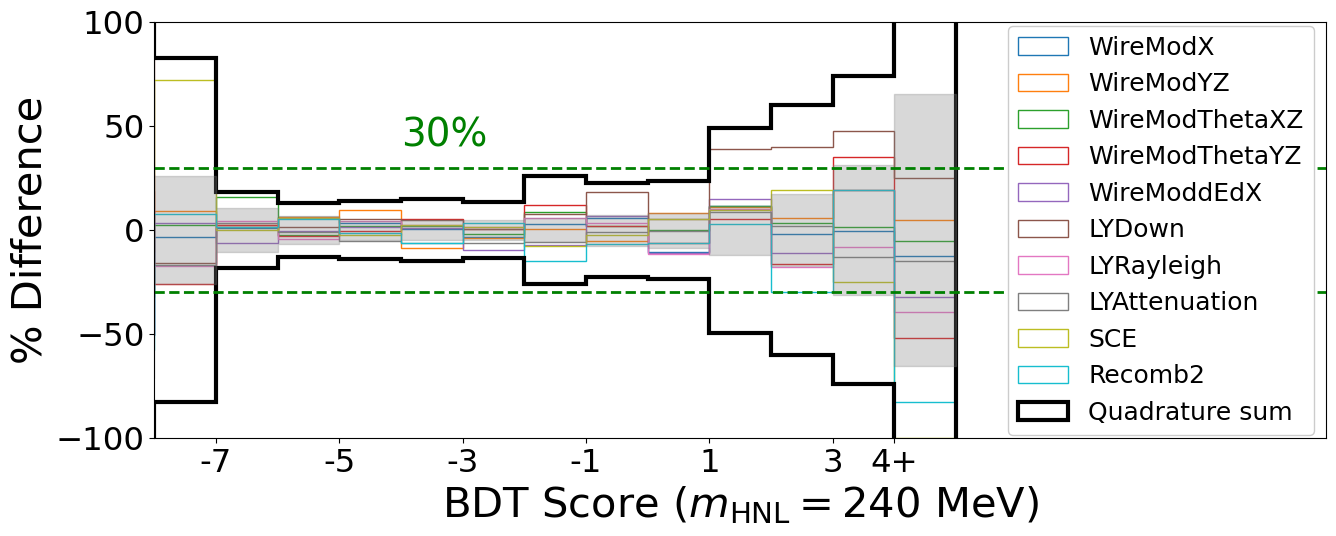

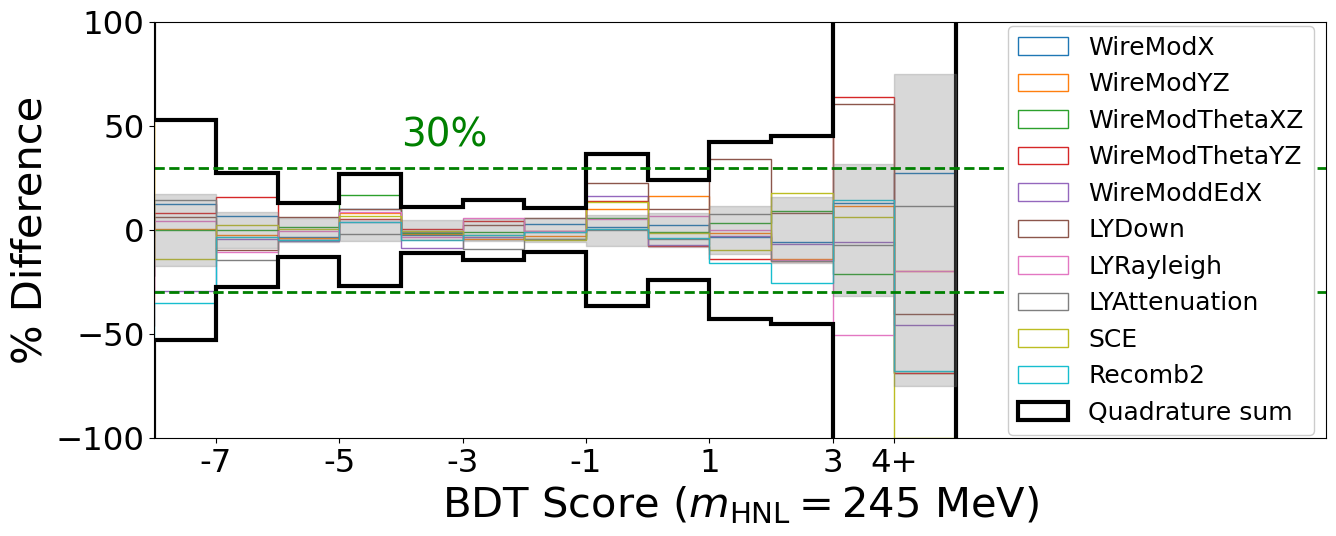

In [11]:
quadsum_dict = Plot_all_detvar_diffs(sample_test_dict, HNL_masses, bins_dict, bins_cents_overflow, bins_overflow, 
                                     xlims_dict, xticks_dict,vals_dict, xlim_start=-8,y_lim=100, bin_padding=6, hlines=[30])

In [12]:
#Capping the DetVar uncertainty fraction on each bin.
flat_overlay_detvar = 0.3
cap = flat_overlay_detvar
capped_quadsum = {}

for HNL_mass in quadsum_dict:
    nbins = len(quadsum_dict[HNL_mass])
    capped_hist = np.zeros(nbins)
    for j, frac in enumerate(quadsum_dict[HNL_mass]):
        if frac > cap: capped_hist[j] = cap
        elif frac == 0.0: capped_hist[j] = cap
        else: capped_hist[j] = frac
    capped_quadsum[HNL_mass] = capped_hist
    
print(capped_quadsum)

{150: array([0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
       0.25128812, 0.17450773, 0.15298583, 0.28382283, 0.19731777,
       0.3       , 0.28214891, 0.3       , 0.3       , 0.3       ,
       0.3       , 0.3       ]), 180: array([0.3       , 0.3       , 0.3       , 0.3       , 0.23593478,
       0.19002726, 0.17036849, 0.23345101, 0.24410035, 0.12893739,
       0.26166178, 0.3       , 0.3       , 0.3       , 0.3       ,
       0.3       ]), 200: array([0.3       , 0.3       , 0.3       , 0.23456567, 0.18385289,
       0.1168982 , 0.15148133, 0.3       , 0.18425019, 0.3       ,
       0.25036369, 0.3       , 0.3       , 0.3       , 0.3       ,
       0.3       ]), 220: array([0.3       , 0.3       , 0.26274439, 0.19050663, 0.17898441,
       0.14553782, 0.14169859, 0.2064151 , 0.1867316 , 0.3       ,
       0.25068815, 0.3       , 0.3       , 0.3       ]), 240: array([0.3       , 0.3       , 0.18449438, 0.13172155, 0.13888133,
       0.14946196, 0.13532813, 0.26103

In [13]:
flat_overlay_detvar = 0.3 #The fraction of overlay detector variation error
# flat_signal_detvar = 0.2 #The fraction of signal detector variation error
overlay_detvar_dict, overlay_detvar_frac_dict = {}, {}
# signal_detvar_dict, signal_detvar_frac_dict = {}, {}

loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True: loc_hists=loc_hists+"pi0/"
    
#I run through the actual overlay DetVar quadrature sum and cap at 50%
for HNL_mass in HNL_masses: #saved_loc+Params["Run"]+f'_{HNL_mass}_'+filename
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file:
        bkg_vals_placeholder=file['bkg_overlay'].values()
    overlay_detvar_dict[HNL_mass] = np.multiply(bkg_vals_placeholder,capped_quadsum[HNL_mass])
    overlay_detvar_frac_dict[HNL_mass] = np.ones_like(bkg_vals_placeholder)*capped_quadsum[HNL_mass]

print("Made all uncertainties")


Made all uncertainties


## Saving .root files with DetVar uncertainties

In [14]:
loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True: loc_hists=loc_hists+"pi0/"

for HNL_mass in HNL_masses:
    bins_cent=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2

    values_dict = {'overlay_DetVar_uncertainty': overlay_detvar_dict[HNL_mass], 
                   'overlay_DetVar_uncertainty_frac': overlay_detvar_frac_dict[HNL_mass]} 
 
    hist_samples = {}

    #make array with all values 1, then weight by value
    for name in values_dict:
        test_hist = np.histogram(bins_cent, weights=values_dict[name], bins=bins_dict[HNL_mass], 
                                 range=[bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
        hist_samples[name] = test_hist

    stop_writing = False
    dont_save = []
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file: #Check what is already in the file (read-only)
        for name in hist_samples:
            if str(name)+";1" in file.keys():
                dont_save.append(name)

    with uproot.update(loc_hists+Params["Run"]+f'_{HNL_mass}_'+filename) as file: #Add new hists into the file
        for name in hist_samples:
            if name in dont_save:
                print(f"Not saving {name}")
            else:
                file[name] = hist_samples[name]
                
print("Done")

Done


## Printing specific bin numbers

In [ ]:
for HNL_mass in HNL_masses:
    print(f"{HNL_mass}MeV")
    bins = bins_dict[HNL_mass]
    nbins = len(bins)-1
    xrange = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]]
    print(np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),range=xrange,bins=bins,weights=sample_test_dict["CV"]["weight"])[0])
    print(np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),range=xrange,bins=bins)[0]) #unweighted

## End of code